# Predição de desenvolvimento de doença cardíaca coronária em até 10 anos usando regressão logística


### Importar Dependências


In [ ]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

### Base de dados

Clique [aqui](https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression) para baixar o arquivo da base de dados framingham.csv



In [ ]:
data = pd.read_csv("framingham.csv")


### Pré-processamento

> Eliminar as linhas que contêm valores nulos, pois elas não contêm todas as informações referentes ao paciente.

> Separar a variável alvo `alv`, que representa se o paciente teve doença cardíaca em 10 anos, do restante `res`

In [ ]:
data.dropna(axis = 0, inplace = True)

alv = data.TenYearCHD.values
res = data.drop(['TenYearCHD'], axis = 1)

In [ ]:
normalizer = Normalizer()
res = normalizer.fit_transform(res)

> Separar 20% dos dados serão usados para teste (`subset_b`), enquanto 80% serão usados para treinamento (`subset_a`).


In [ ]:
splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for subset_a_idx, subset_b_idx in splitter.split(res):
    res_subset_a, res_subset_b = res[subset_a_idx].T, res[subset_b_idx].T
    alv_subset_a, alv_subset_b = alv[subset_a_idx].T, alv[subset_b_idx].T

# Regressão Logística

O valor $z^{(i)}$ é o resultado da combinação linear entre os pesos $w$, as características $res^{(i)}$ e o viés bb. Assim, calcula-se uma estimativa inicial com base nos pesos, entradas e viés.

$$ z^{(i)} = w^T res^{(i)} + b $$

---

A função sigmoide transforma $z^{(i)}$ em uma probabilidade, restringindo seu valor ao intervalo [0,1].

$$\hat{alv}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$

---

A entropia cruzada binária mede a diferença entre a predição $a^{(i)}$ (saída do modelo) e o valor real $alv^{(i)}$. Penalizando predições incorretas de maneira proporcional à distância da predição ao valor verdadeiro.

$$ \mathcal{L}(a^{(i)}, alv^{(i)}) =  - alv^{(i)}  \log(a^{(i)}) - (1-alv^{(i)} )  \log(1-a^{(i)})$$

---

O custo total $J$ é a média das perdas $\mathcal{L}$ para todas as $m$ amostras. Este valor é usado para avaliar o desempenho do modelo e orientar o treinamento, pois resume as perdas de todas as amostras, fornecendo um único valor que guia o processo de otimização.
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, alv^{(i)})$$

> Função para inicializar os parâmetros de um modelo com zeros para um dado número de variáveis

In [ ]:
def initialize_parameters(variables):
    weights = np.zeros((variables, 1))
    bias = 0
    return weights, bias

## Função Sigmoide

A função sigmoide é usada para converter um valor em uma probabilidade no intervalo \[0, 1]\:


$$sigmoid(w^T res + b) = \frac{1}{1 + e^{-(w^T res + b)}}
$$

Onde:
- $w^T res + b$ é a combinação linear das características `res`, pesos `w` e viés `b`.
- A função sigmoide mapeia o valor de entrada para uma probabilidade.


In [ ]:
def sigmoid(z):
    """
    Calcula a função sigmoide de uma entrada escalar ou matriz.

    Parâmetros:
        z (float ou np.array): Valor escalar ou array de entrada.

    Retorna:
        float ou np.array: Resultado da aplicação da função sigmoide.
    """
    return 1 / (1 + np.exp(-z))

## Propagação na Regressão Logística

**Propagação direta**

Durante a propagação direta, calculamos a predição $A$ usando a função sigmoide:

$$ A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, \dots, a^{(m)}) $$

**Função de custo**

A função de custo mede o erro da predição em relação aos valores reais:
$$ J = -\frac{1}{m} \sum_{i=1}^{m} \Big[ y^{(i)} \log(a^{(i)}) + (1-y^{(i)}) \log(1-a^{(i)}) \Big] $$

**Propagação inversa**

Para otimizar os pesos $w$ e o viés $b$, calculamos os gradientes:

Gradiente em relação aos pesos:

$$ \frac{\partial J}{\partial w} = \frac{1}{m} X (A - Y)^T $$

Gradiente em relação ao viés:

$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)} - y^{(i)}) $$

Esses gradientes são usados no processo de descida do gradiente para ajustar os parâmetros.


In [ ]:
def propagate(weights, bias, features, labels):
    """
    Executa a propagação direta e inversa na regressão logística.

    Parâmetros:
        weights (np.array): Vetor de pesos, de dimensão (num_features, 1).
        bias (float): Viés escalar.
        features (np.array): Matriz de entradas (num_features, num_samples).
        labels (np.array): Vetor de rótulos reais (1, num_samples).

    Retorna:
        dict: Gradientes "dw" (pesos) e "db" (viés).
        float: Custo total.
    """

    num_samples = features.shape[1]

    z = np.dot(weights.T, features) + bias
    predictions = sigmoid(z)
    loss = - (labels * np.log(predictions) + (1 - labels) * np.log(1 - predictions))
    cost = np.sum(loss) / num_samples

    dw = (1 / num_samples) * np.dot(features, (predictions - labels).T)
    db = (1 / num_samples) * np.sum(predictions - labels)

    gradients = {"dw": dw, "db": db}

    return gradients, cost


## Atualização de Pesos e Viés

Durante o treinamento do modelo, o objetivo é ajustar os pesos $w$ e o viés $b$ para minimizar o custo. A atualização dos parâmetros é feita usando a fórmula do gradiente descendente:

$$ w = w - \text{learning rate} \times \frac{\partial J}{\partial w} $$

$$ b = b - \text{learning rate} \times \frac{\partial J}{\partial b} $$

A cada iteração, calculamos os gradientes $\frac{\partial J}{\partial w}$ e $\frac{\partial J}{\partial b}$ e ajustamos os pesos e viés de acordo. Tentamos minimizar o custo ao longo das iterações, registrando o valor do custo em intervalos específicos.


In [ ]:
def update_weights_and_bias(weights, bias, features, labels, num_iterations, learning_rate):
    """
    Atualiza os pesos e o viés usando o algoritmo de gradiente descendente.

    Parâmetros:
        weights (np.array): Vetor de pesos, de dimensão (num_features, 1).
        bias (float): Viés escalar.
        features (np.array): Matriz de entradas (num_features, num_samples).
        labels (np.array): Vetor de rótulos reais (1, num_samples).
        num_iterations (int): Número de iterações do treinamento.
        learning_rate (float): Taxa de aprendizado para ajustar os parâmetros.

    Retorna:
        dict: Parâmetros atualizados ("weights" e "bias").
        dict: Gradientes finais ("dw" e "db").
        list: Histórico de custos a cada 20 iterações.
    """
    costs = []

    for iteration in range(num_iterations):
        gradients, cost = propagate(weights, bias, features, labels)

        dw = gradients['dw']
        db = gradients['db']

        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Essa parte do código tem como objetivo armazenar o valor do custo a cada 20 iterações do treinamento
        # Assim, você consegue visualizar a tendência do custo sem que os dados fiquem excessivamente densos.
        if iteration % 20 == 0:
            costs.append(cost)

    parameters = {"w": weights, "b": bias}
    gradients = {"dw": dw, "db": db}

    return parameters, gradients, costs


## Predição

Após treinar o modelo, podemos usá-lo para fazer predições sobre novos dados. A predição é realizada aplicando a função sigmoide aos dados de entrada `res`, com os pesos $w$ e o viés $b$. A fórmula é a seguinte:

$$ \hat{alv} = A = \sigma(w^T res + b) $$

O valor final de $\hat{alv}$ será 1 se a probabilidade for maior que 0.5, caso contrário será 0.

A predição de $\hat{alv}$ nos permite classificar os dados em duas categorias.


In [ ]:
def predict(weights, bias, features):
    """
    Realiza a predição com base nos dados de entrada, pesos e viés.

    Parâmetros:
        weights (np.array): Vetor de pesos, de dimensão (num_features, 1).
        bias (float): Viés escalar.
        features (np.array): Matriz de entradas (num_features, num_samples).

    Retorna:
        np.array: Vetor de predições (1, num_samples), onde 1 indica a classe positiva e 0 a classe negativa.
    """
    num_samples = features.shape[1]
    Y_prediction = np.zeros((1, num_samples))
    weights = weights.reshape(features.shape[0], 1)

    # Cálculo da predição
    A = sigmoid(np.dot(weights.T, features) + bias)

    # Classificação com base na probabilidade
    for i in range(A.shape[1]):
        if A[:, i] > 0.5:
            Y_prediction[:, i] = 1  # Classifica como 1 se a probabilidade for maior que 0.5

    return Y_prediction


O valor 0.5 é comumente utilizado como limiar em modelos de classificação binária que utilizam a função sigmoide, porque ele representa o ponto de equilíbrio entre as duas classes. A função sigmoide mapeia os valores de entrada para o intervalo entre 0 e 1, onde a saída é interpretada como uma probabilidade. Quando a probabilidade é maior que 0.5, o modelo classifica a amostra como pertencente à classe positiva (classe 1); se for menor que 0.5, a amostra é classificada como classe negativa (classe 0). O valor 0.5 é escolhido porque ele indica um ponto de decisão neutro, onde o modelo não tem uma preferência clara por nenhuma das classes, sendo ideal para problemas onde ambas as classes têm importância equivalente. No entanto, o limiar pode ser ajustado em casos específicos onde há necessidade de reduzir falsos positivos ou falsos negativos, como em problemas de detecção de fraudes, por exemplo.

## Modelo de Regressão Logística

O modelo de regressão logística é integrado usando as funções definidas anteriormente. Para este conjunto de dados, temos 14 atributos (ou características) na variável independente, então inicializamos os pesos $w$ e o viés $b$ com a dimensão correspondente.

A sequência de operações inclui:
1. Inicialização dos pesos e viés.
2. Atualização dos parâmetros usando gradiente descendente.
3. Predição do modelo para o conjunto de teste.
4. Cálculo da acurácia, comparando as predições com os valores reais.
5. Retorno de um dicionário contendo as predições, pesos, viés e histórico de custos.

O objetivo final é treinar o modelo e verificar sua acurácia no conjunto de testes.


In [ ]:
def Logistic_Regression_model(X_train, X_test, Y_train, Y_test, num_iterations, learning_rate):
    # Inicializar parâmetros
    num_features = X_train.shape[0]
    w, b = initialize_parameters(num_features)

    # Atualizar pesos e viés
    parameters, gradient, costs = update_weights_and_bias(w, b, X_train, Y_train, num_iterations, learning_rate)

    # Obter os pesos finais
    w = parameters["w"]
    b = parameters["b"]

    # Fazer previsões nos dados de teste
    Y_Test_Predict = (predict(w, b, X_test) > 0.5).astype(int).reshape(-1)

    # Garantir que Y_Test_Predict tenha a forma correta
    Y_Test_Predict = Y_Test_Predict.reshape(-1)

    # Calcular a acurácia
    accuracy = 100 - np.mean(np.abs(Y_Test_Predict - Y_test)) * 100

    print(f"Acurácia: {accuracy} %")

    # Armazenar as predições, pesos, viés e custo
    Dictionary = {"Predição": Y_Test_Predict,
                  "Peso": w,
                  "Viés": b,
                  "Custo": costs,
                  "Acurácia": accuracy}

    return Dictionary


In [ ]:
Dictionary = Logistic_Regression_model(res_subset_a, res_subset_b, alv_subset_a, alv_subset_b, num_iterations = 1000, learning_rate = 0.10 )


Acurácia: 84.0 %


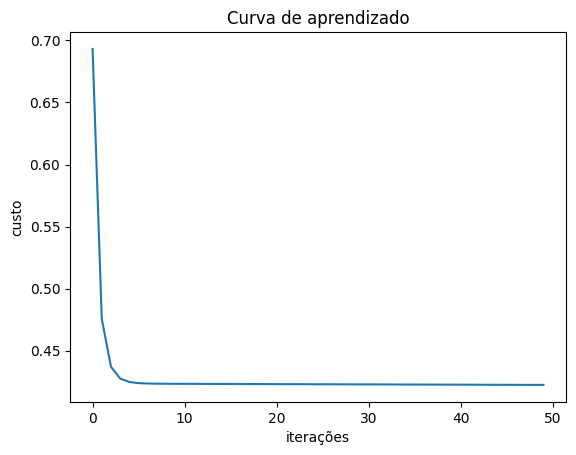

In [ ]:
import matplotlib.pyplot as plt
costs = np.squeeze(Dictionary['Custo'])
plt.plot(costs)
plt.ylabel('custo')
plt.xlabel('iterações')
plt.title("Curva de aprendizado")
plt.show()

Para garantir a precisão do nosso modelo, utilizamos o classificador de Regressão Logística do Sklearn.

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(res_subset_a.T,alv_subset_a.T)
print("Acurácia {}".format(lr.score(res_subset_a.T,alv_subset_a.T)))

Acurácia 0.8492830943647882


## Créditos

Partes dos códigos implementados neste notebook foram adaptadas do repositório [Heart Disease Prediction using Logistic Regression](https://github.com/tproma/Heart-Disease-Prediction-using-Logistic-Regression/tree/master), que está licenciado sob a [Licença Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0).

Conforme os termos da licença, foi mantida a devida atribuição ao autor original e todas as modificações realizadas foram explicitamente indicadas neste trabalho.
